# SBI with iid data and permutation-invariant embeddings

There are scenarios in which we observe multiple data points per experiment and we can assume that they are independent and identically distributed (iid, i.e., they are assumed to have the same underlying model parameters).
For example, in decision-making experiments, the experiment is often repeated in trials with the same experimental settings and conditions. The corresponding set of trials is then assumed to be "iid" given a single parameter set.
In such a scenario, we may want to obtain the posterior given a set of observation $p(\theta | X=\{x_i\}_i^N)$.

### Amortization of neural network training: iid-inference with NLE / NRE

For some SBI variants the iid assumption can be exploited: when using a likelihood-based SBI method (`SNLE`, `SNRE`) one can train the density or ratio estimator on single-trial data, and then perform inference with `MCMC` or variational inference (`VI`). Crucially, because the data is iid and the estimator is trained on single-trial data, one can repeat the inference with a different `x_o` (a different set of trials, or different number of trials) without having to retrain the density estimator. One can interpet this as amortization of the SBI training: we can obtain a neural likelihood, or likelihood-ratio estimate for new `x_o`s without retraining, but we still have to run `MCMC` or `VI` to do inference.

In addition, one cannot only change the number of trials of a new `x_o`, but also the entire inference setting.
For example, one can apply hierarchical inference with changing hierarchical denpendencies between the model parameters--all without having to retrain the density estimator because it estimates single-trail likelihoods.

### Full amortization: iid-inference with NPE and permutation-invariant embedding nets

When performing neural posterior estimation (`SNPE`) we cannot exploit the iid assumption directly.
Thus, the underlying neural network takes `x` as input and predicts the parameters of the density estimator.
As a consequence, if `x` is a set of iid observations $X=\{x_i\}_i^N$ then the neural network has to be invariant to permutations of this set, i.e., it has to be permutation invariant. In addition, the neural network has to be able to consume a varying number of iid datapoints in order to be amortized over the number of trials.
Therefore, in order to use `SNPE` for inference on iid data, we need to provide a corresponding embedding network that handles the iid-data.
This will likely require some hyperparameter tuning and more training data for inference to work accurately. But once we have this, inference is fully amortized, i.e., we can get new posterior samples almost instantly without retraining and without running `MCMC` or `VI`.


## SBI with trial-based data

For illustration, we use a simple linear Gaussian simulator, as in previous tutorials. The simulator takes a single parameter (vector) which is the mean of a Gaussian. The simulator then adds noise with a fixed variance (set to one).
We define a Gaussian prior over the mean and perform inference.

The observed data is also sampled from a Gaussian with some fixed "ground-truth" parameter $\theta_o$.
Crucially, the observed data `x_o` can consist of multiple samples given the same ground-truth parameters and these samples are iid given $\theta$:

$$
\theta \sim \mathcal{N}(\mu_0,\; \Sigma_0) \\
x | \theta \sim \mathcal{N}(\theta,\; \Sigma=I) \\
\mathbf{x_o} = \{x_o^i\}_{i=1}^N \sim  \mathcal{N}(\theta_o,\; \Sigma=I)
$$

For this toy problem, the ground-truth posterior is well defined, it is again a Gaussian, centered on the mean of $\mathbf{x_o}$ and with variance scaled by the number of trials $N$, i.e., the more trials we observe, the more information about the underlying $\theta_o$ we have and the more concentrated the posteriors becomes.

We will illustrate this below:


In [1]:
import matplotlib.pyplot as plt
import torch
from torch import eye, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import pairplot
from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.simulators.linear_gaussian import (
    linear_gaussian,
    true_posterior_linear_gaussian_mvn_prior,
)
from sbi.utils.metrics import c2st

# Seeding
torch.manual_seed(1);

In [2]:
# Gaussian simulator
theta_dim = 2
x_dim = theta_dim

# likelihood_mean will be likelihood_shift+theta
likelihood_shift = -1.0 * zeros(x_dim)
likelihood_cov = 0.3 * eye(x_dim)

prior_mean = zeros(theta_dim)
prior_cov = eye(theta_dim)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)

# Define Gaussian simulator
simulator, prior = prepare_for_sbi(
    lambda theta: linear_gaussian(theta, likelihood_shift, likelihood_cov), prior
)


# Use built-in function to obtain ground-truth posterior given x_o
def get_true_posterior_samples(x_o, num_samples=1):
    return true_posterior_linear_gaussian_mvn_prior(
        x_o, likelihood_shift, likelihood_cov, prior_mean, prior_cov
    ).sample((num_samples,))

### The analytical posterior concentrates around true parameters with increasing number of IID trials


In [3]:
num_trials = [1, 5, 15, 20]
theta_o = zeros(1, theta_dim)

# Generate multiple x_os with increasing number of trials.
xos = [theta_o.repeat(nt, 1) for nt in num_trials]

# Obtain analytical posterior samples for each of them.
true_samples = [get_true_posterior_samples(xo, 5000) for xo in xos]

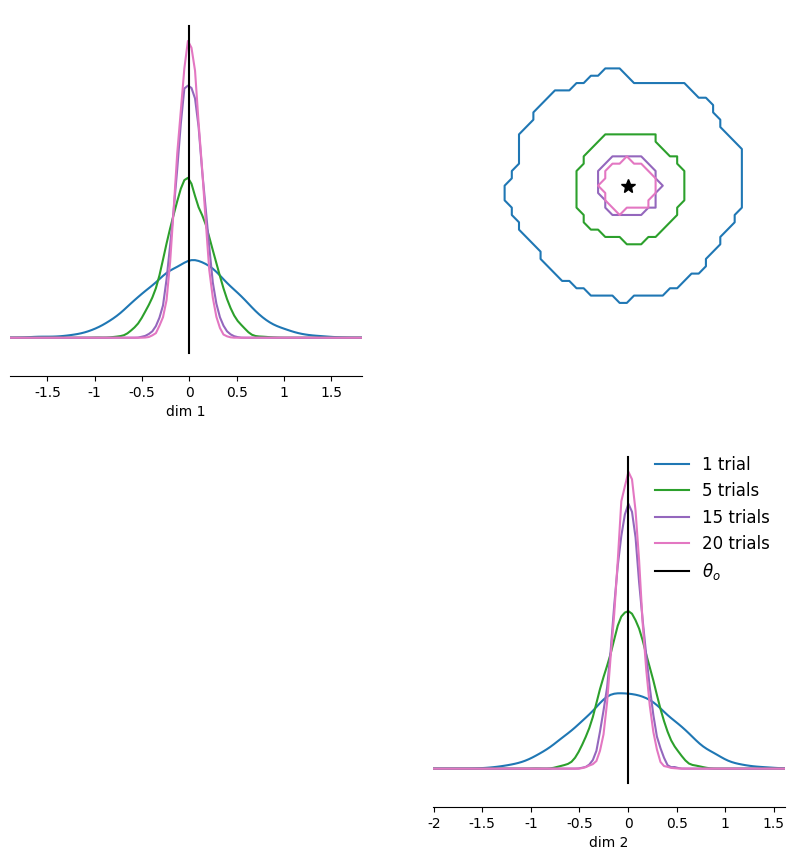

In [4]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    true_samples,
    points=theta_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
)
plt.sca(ax[1, 1])
plt.legend(
    [f"{nt} trials" if nt > 1 else f"{nt} trial" for nt in num_trials]
    + [r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

Indeed, with increasing number of trials the posterior density concentrates around the true underlying parameter.


## IID inference with NLE

(S)NLE and (S)NRE can perform inference given multiple IID obserations by using only single-trial training data (i.e., for training, we run the simulator only once per parameter set). Once the likelihood is learned on single trials (i.e., a neural network that predicts the likelihood of a single observation given a parameter set), one can sample the posterior for any number of trials. This works because, given a single-trial neural likelihood from (S)NLE or (S)NRE, we can calculate the joint likelihoods of all trials by multiplying them together (or adding them in log-space). The joint likelihood can then be plugged into `MCMC` or `VI`. `sbi` takes care of all of these steps, so you do not have to implement anything yourself:


In [5]:
# Train SNLE.
inferer = SNLE(prior, show_progress_bars=True, density_estimator="mdn")
theta, x = simulate_for_sbi(simulator, prior, 10000, simulation_batch_size=1000)
inferer.append_simulations(theta, x).train(training_batch_size=1000);

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 47 epochs.

In [6]:
# Obtain posterior samples for different number of iid xos.
nle_samples = []
num_samples = 5000

mcmc_parameters = dict(
    num_chains=50,
    thin=5,
    warmup_steps=10,
    init_strategy="proposal",
)
mcmc_method = "slice_np_vectorized"

posterior = inferer.build_posterior(
    mcmc_method=mcmc_method,
    mcmc_parameters=mcmc_parameters,
)

# Generate samples with MCMC given the same set of x_os as above.
for xo in xos:
    nle_samples.append(posterior.sample(sample_shape=(num_samples,), x=xo))

Running vectorized MCMC with 50 chains:   0%|          | 0/27500 [00:00<?, ?it/s]

/Users/janteusen/qode/sbi/sbi/utils/sbiutils.py:341: UserWarning: An x with a batch size of 5 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 50 chains:   0%|          | 0/27500 [00:00<?, ?it/s]

/Users/janteusen/qode/sbi/sbi/utils/sbiutils.py:341: UserWarning: An x with a batch size of 15 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 50 chains:   0%|          | 0/27500 [00:00<?, ?it/s]

/Users/janteusen/qode/sbi/sbi/utils/sbiutils.py:341: UserWarning: An x with a batch size of 20 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 50 chains:   0%|          | 0/27500 [00:00<?, ?it/s]

Note that `sbi` warns about `iid-x` with increasing number of trial here. We ignore the warning because that's exactly what we want to do.


/Users/janteusen/qode/sbi/sbi/analysis/plot.py:116: RuntimeWarning: invalid value encountered in divide
  cum_probs /= cum_probs[-1]


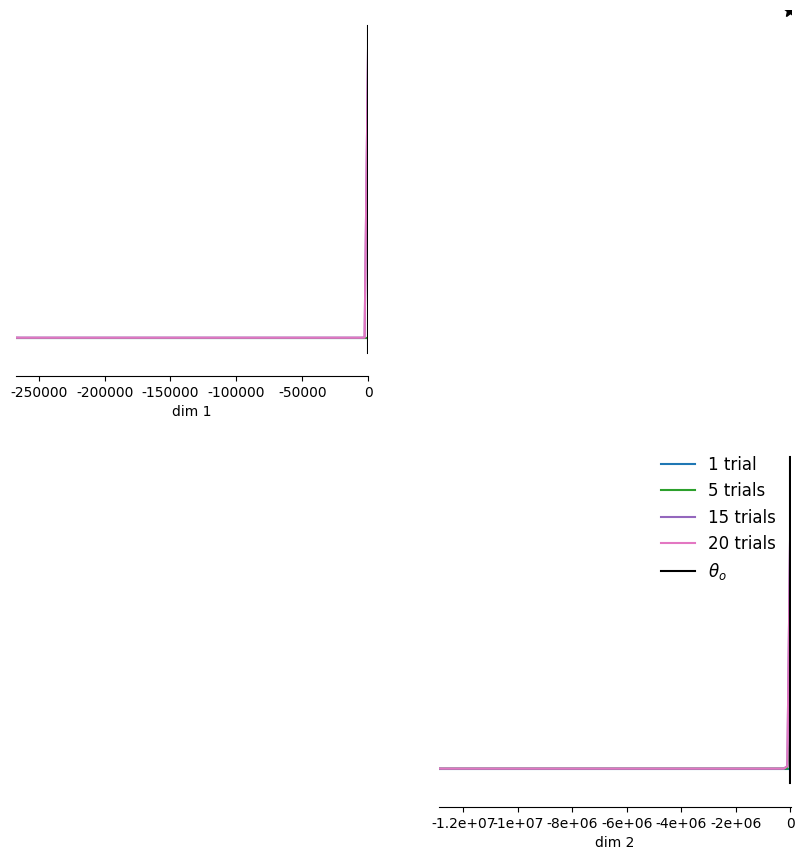

In [7]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    nle_samples,
    points=theta_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
)
plt.sca(ax[1, 1])
plt.legend(
    [f"{nt} trials" if nt > 1 else f"{nt} trial" for nt in num_trials]
    + [r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

The pairplot above already indicates that (S)NLE is well able to obtain accurate posterior samples also for increasing number of trials (note that we trained the single-round version of SNLE so that we did not have to re-train it for new $x_o$).

Quantitatively we can measure the accuracy of SNLE by calculating the `c2st` score between SNLE and the true posterior samples, where the best accuracy is perfect for `0.5`:


In [8]:
cs = [
    c2st(torch.from_numpy(s1), torch.from_numpy(s2))
    for s1, s2 in zip(true_samples, nle_samples)
]

for _ in range(len(num_trials)):
    print(f"c2st score for num_trials={num_trials[_]}: {cs[_].item():.2f}")

c2st score for num_trials=1: 0.50
c2st score for num_trials=5: 0.49
c2st score for num_trials=15: 0.52
c2st score for num_trials=20: 0.51


## IID inference with NPE using permutation-invariant embedding nets

For NPE we need to define an embedding net that handles the set-like structure of iid-data, i.e., that it permutation invariant and can handle different number of trials.

We implemented several embedding net classes that allow to construct such a permutation- and number-of-trials invariant embedding net.

To become permutation invariant, the neural net first learns embeddings for single trials and then performs a permutation invariant operation on those embeddings, e.g., by taking the sum or the mean (Chen et al. 2018, Radev et al. 2021).

To become invariant w.r.t. the number-of-trials, we train the net with varying number of trials for each parameter setting. This means that, unlike for (S)NLE and (S)NRE, (S)NPE requires to run the simulator multiple times for individual parameter sets to generate the training data.

In order to implement this in `sbi`, "unobserved" trials in the training dataset have to be masked by NaNs (and ignore the resulting SBI warning about NaNs in the training data).

### Construct training data set.


In [9]:
# we need to fix the maximum number of trials.
max_num_trials = 20

# construct training data set: we want to cover the full range of possible number of
# trials
num_training_samples = 5000
theta = prior.sample((num_training_samples,))

# there are certainly smarter ways to construct the training data set, but we go with a
# for loop here for illustration purposes.
x = torch.ones(num_training_samples * max_num_trials, max_num_trials, x_dim) * float(
    "nan"
)
for i in range(num_training_samples):
    xi = simulator(theta[i].repeat(max_num_trials, 1))
    for j in range(max_num_trials):
        x[i * max_num_trials + j, : j + 1, :] = xi[: j + 1, :]

theta = theta.repeat_interleave(max_num_trials, dim=0)

### Build embedding net


In [10]:
from sbi.neural_nets.embedding_nets import (
    FCEmbedding,
    PermutationInvariantEmbedding,
)
from sbi.utils import posterior_nn

# embedding
latent_dim = 10
single_trial_net = FCEmbedding(
    input_dim=theta_dim,
    num_hiddens=40,
    num_layers=2,
    output_dim=latent_dim,
)
embedding_net = PermutationInvariantEmbedding(
    single_trial_net,
    trial_net_output_dim=latent_dim,
    # NOTE: post-embedding is not needed really.
    num_layers=1,
    num_hiddens=10,
    output_dim=10,
)

# we choose a simple MDN as the density estimator.
# NOTE: we turn off z-scoring of the data, as we used NaNs for the missing trials.
density_estimator = posterior_nn("mdn", embedding_net=embedding_net, z_score_x="none")

### Run training


In [11]:
inference = SNPE(prior, density_estimator=density_estimator)
# NOTE: we don't exclude invalid x because we used NaNs for the missing trials.
inference.append_simulations(
    theta,
    x,
    exclude_invalid_x=False,
).train(training_batch_size=1000)
posterior = inference.build_posterior()

 Neural network successfully converged after 165 epochs.

### Amortized inference

Comparing runtimes, we see that the NPE training takes a bit longer than the training on single trials for `NLE` above.

However, we trained the density estimator such that it can handle multiple and changing number of iid trials (up to 20).

Thus, we can obtain posterior samples for different `x_o` with just a single forward pass instead of having to run `MCMC` for each new observation.

As you can see below, the c2st score for increasing number of observed trials remains close to the ideal `0.5`.


In [12]:
npe_samples = []
for xo in xos:
    # we need to pad the x_os with NaNs to match the shape of the training data.
    xoi = torch.ones(1, max_num_trials, x_dim) * float("nan")
    xoi[0, : len(xo), :] = xo
    npe_samples.append(posterior.sample(sample_shape=(num_samples,), x=xoi))

cs = [c2st(torch.from_numpy(s1), s2) for s1, s2 in zip(true_samples, npe_samples)]

for _ in range(len(num_trials)):
    print(f"c2st score for num_trials={num_trials[_]}: {cs[_].item():.2f}")

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

c2st score for num_trials=1: 0.52
c2st score for num_trials=5: 0.52
c2st score for num_trials=15: 0.52
c2st score for num_trials=20: 0.54


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

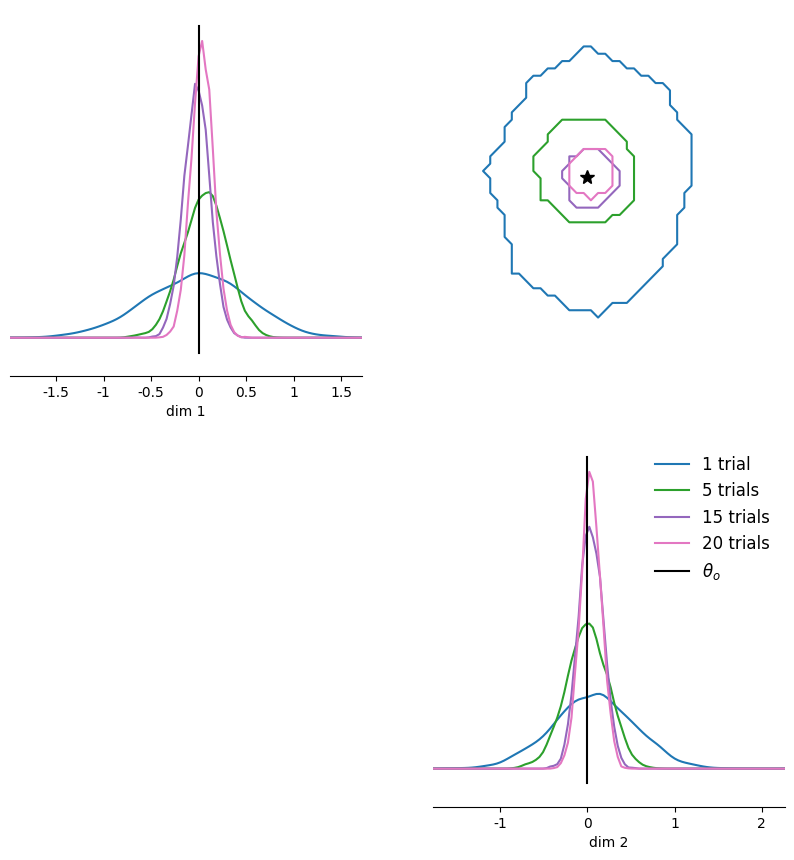

In [13]:
num_trials = [1, 5, 15, 20]
xos = [theta_o.repeat(nt, 1) for nt in num_trials]

npe_samples = []
for xo in xos:
    # we need to pad the x_os with NaNs to match the shape of the training data.
    xoi = torch.ones(1, max_num_trials, x_dim) * float("nan")
    xoi[0, : len(xo), :] = xo
    npe_samples.append(posterior.sample(sample_shape=(num_samples,), x=xoi))


# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    npe_samples,
    points=theta_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
)
plt.sca(ax[1, 1])
plt.legend(
    [f"{nt} trials" if nt > 1 else f"{nt} trial" for nt in num_trials]
    + [r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

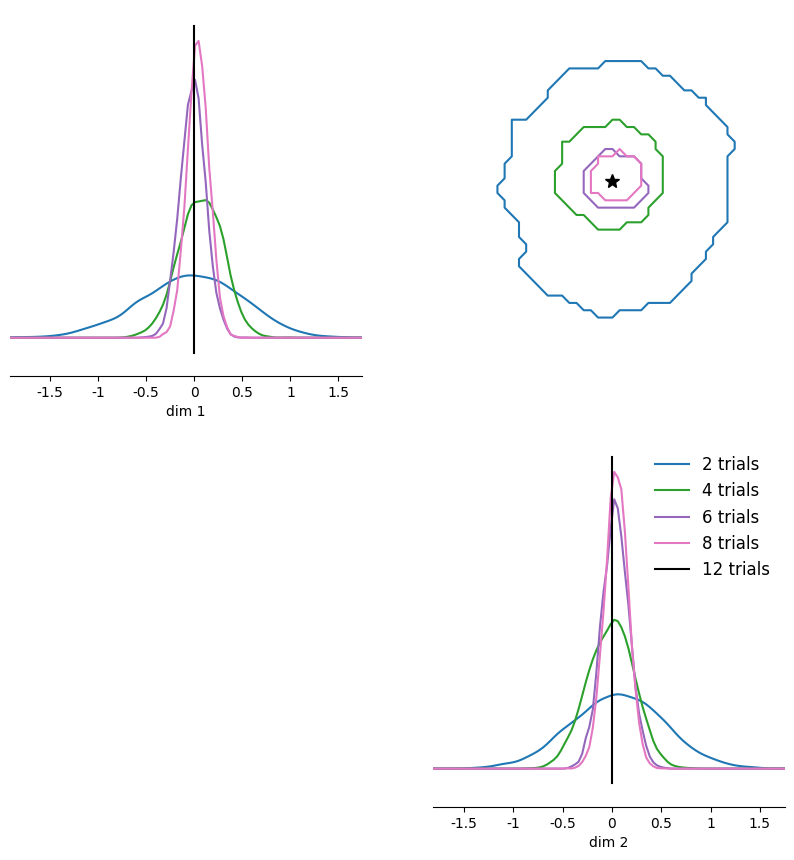

In [14]:
# We can easily obtain posteriors for many different x_os, instantly, because
# NPE is fully amortized:
num_trials = [2, 4, 6, 8, 12, 14, 18]
npe_samples = []
for xo in xos:
    # we need to pad the x_os with NaNs to match the shape of the training data.
    xoi = torch.ones(1, max_num_trials, x_dim) * float("nan")
    xoi[0, : len(xo), :] = xo
    npe_samples.append(posterior.sample(sample_shape=(num_samples,), x=xoi))


# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    npe_samples,
    points=theta_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
)
plt.sca(ax[1, 1])
plt.legend(
    [f"{nt} trials" if nt > 1 else f"{nt} trial" for nt in num_trials]
    + [r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);